In [2]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.artifacts.anim_artifact import AnimationArtifact

torch.set_grad_enabled(False)

animation_tag = "backflip:latest"

animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)
n_frames = 9
frame_indices = animation.frame_indices(n_frames)
cameras, meshes = animation.load_frames(frame_indices)
# depths = render_depth_map(meshes, cameras)
# display_ims(depths)

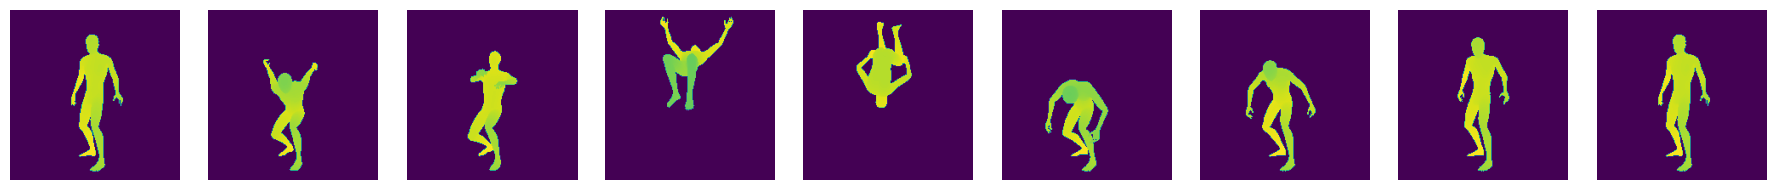

: 

In [3]:
from pytorch3d.renderer import RasterizationSettings, MeshRasterizer

from text3d2video.utilities.ipython_utils import display_ims

raster_settings = RasterizationSettings(
    image_size=200, blur_radius=0.0, faces_per_pixel=1, bin_size=0
)

rasterizer = MeshRasterizer(raster_settings=raster_settings)

# compute fragments
fragments = rasterizer(meshes, cameras=cameras)

display_ims(fragments.zbuf.cpu())

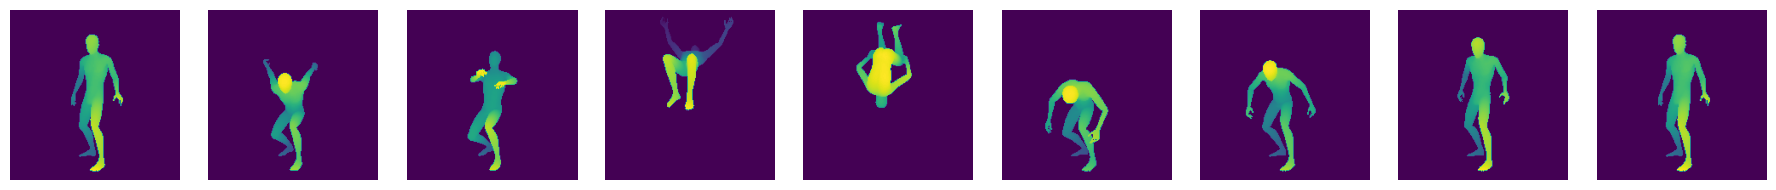

In [6]:
from text3d2video.rendering import zbuf_to_depth_map
import torchvision.transforms.functional as TF

# obtain depth maps from fragments
depth_maps = zbuf_to_depth_map(fragments.zbuf[..., -1])
depth_maps_pil = [TF.to_pil_image(depth_map) for depth_map in depth_maps]

display_ims(depth_maps_pil)

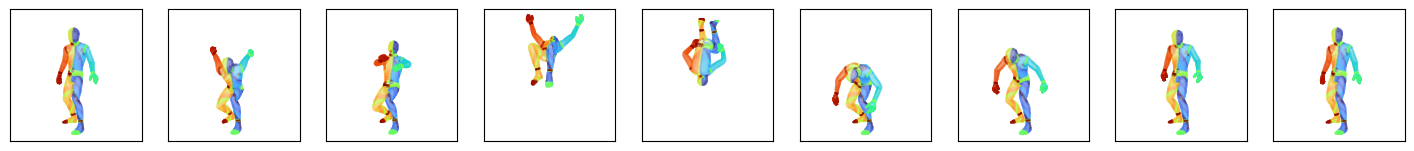

In [7]:
from matplotlib import pyplot as plt
from text3d2video.backprojection import project_visible_verts_to_cameras

# compute visible vertices and their 2D projections in camera space for each frame

vert_xys, vert_indices = project_visible_verts_to_cameras(meshes, cameras)

s = 2
fig, axs = plt.subplots(1, len(vert_xys), figsize=(n_frames * s, s))

for i, ax in enumerate(axs):
    frame_vert_xys = vert_xys[i]
    frame_vert_indices = vert_indices[i]

    ax.scatter(
        frame_vert_xys[:, 0].cpu(),
        frame_vert_xys[:, 1].cpu(),
        s=0.01,
        c=frame_vert_indices.cpu(),
        cmap='turbo'
    )
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])